In [ ]:
from itertools import islice
import random
import math
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

In [15]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

def compute_accuracy(network, dataset, device, N=2000, batch_size=50):
    """Computes accuracy of `network` on `dataset`.
    """
    with torch.no_grad():
        N = min(len(dataset), N)
        batch_size = min(batch_size, N)
        dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        correct = 0
        total = 0
        for x, labels in islice(dataset_loader, N // batch_size):
            logits = network(x.to(device))
            predicted_labels = torch.argmax(logits, dim=1)
            correct += torch.sum(predicted_labels == labels.to(device))
            total += x.size(0)
        return (correct / total).item()

def compute_loss(network, dataset, device, N=2000, batch_size=50):
    """Computes mean loss of `network` on `dataset`.
    """
    with torch.no_grad():
        N = min(len(dataset), N)
        batch_size = min(batch_size, N)
        dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        loss_fn = nn.MSELoss(reduction='sum')
        one_hots = torch.eye(10, 10).to(device)
        total = 0
        points = 0
        for x, labels in islice(dataset_loader, N // batch_size):
            y = network(x.to(device))
            total += loss_fn(y, one_hots[labels]).item()
            points += len(labels)
        return total / points

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 10)
        )

    def forward(self, x):
        return self.layers(x)

# Using fixed configurations: ReLU activation, Adam optimizer, MSE loss

train_points = 1000
optimization_steps = 1000
batch_size = 200
weight_decay = 0.01
lr = 1e-3
initialization_scale = 8.0
download_directory = "."

depth = 3               # the number of nn.Linear modules in the model
width = 200

log_freq = math.ceil(optimization_steps / 150)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
seed = 0

torch.set_default_dtype(dtype)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)

# load dataset
train = torchvision.datasets.MNIST(root=download_directory, train=True, 
    transform=torchvision.transforms.ToTensor(), download=True)
test = torchvision.datasets.MNIST(root=download_directory, train=False, 
    transform=torchvision.transforms.ToTensor(), download=True)
train = torch.utils.data.Subset(train, range(train_points))
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

# create model
mlp = MLP().to(device)
with torch.no_grad():
    for p in mlp.parameters():
        p.data = initialization_scale * p.data

# create optimizer
optimizer = torch.optim.Adam(mlp.parameters(), lr=lr, weight_decay=weight_decay)

# define loss function
loss_fn = nn.MSELoss()


train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
norms = []
last_layer_norms = []
log_steps = []

steps = 0
one_hots = torch.eye(10, 10).to(device)
for x, labels in islice(cycle(train_loader), optimization_steps): # run the train_loader optimization_steps step
        if (steps < 30) or (steps < 150 and steps % 10 == 0) or steps % log_freq == 0:
            train_losses.append(compute_loss(mlp, train, device, N=len(train)))
            train_accuracies.append(compute_accuracy(mlp, train, device, N=len(train)))
            test_losses.append(compute_loss(mlp, test, device, N=len(test)))
            test_accuracies.append(compute_accuracy(mlp, test, device, N=len(test)))
            log_steps.append(steps)
            with torch.no_grad():
                total = sum(torch.pow(p, 2).sum() for p in mlp.parameters())
                norms.append(float(np.sqrt(total.item())))
                last_layer = sum(torch.pow(p, 2).sum() for p in mlp.layers[-1].parameters())
                last_layer_norms.append(float(np.sqrt(last_layer.item())))

        optimizer.zero_grad()
        y = mlp(x.to(device))
        loss = loss_fn(y, one_hots[labels])
        loss.backward()
        optimizer.step()
        steps += 1
    

Text(0.5, 1.0, 'depth-3 width-200 ReLU MLP on MNIST\nUnconstrained Optimization α = 8.0')

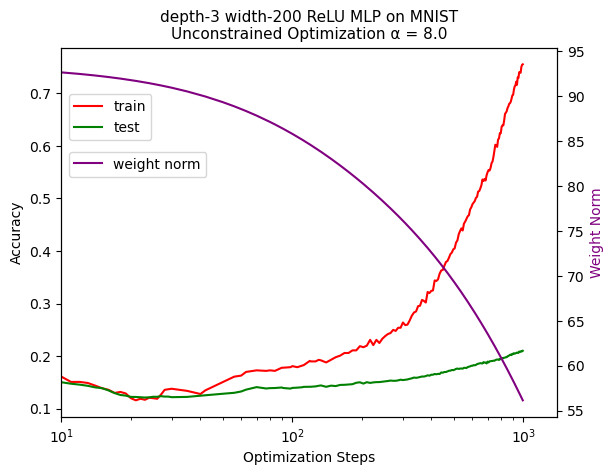

In [16]:
ax = plt.subplot(1, 1, 1)
plt.plot(log_steps, train_accuracies, color='red', label='train')
plt.plot(log_steps, test_accuracies, color='green', label='test')
plt.xscale('log')
plt.xlim(10, None)
plt.xlabel("Optimization Steps")
plt.ylabel("Accuracy")
plt.legend(loc=(0.015, 0.75))

ax2 = ax.twinx()
ax2.set_ylabel("Weight Norm", color='purple')
ax2.plot(log_steps, norms, color='purple', label='weight norm')
# ax2.set_ylim(27, 63)
plt.legend(loc=(0.015, 0.65))
plt.title(f"depth-3 width-200 ReLU MLP on MNIST\nUnconstrained Optimization α = {initialization_scale}", fontsize=11)
# plt.tight_layout()